In [1]:
import torch
import matplotlib.pyplot as plt
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
from mmengine import Config
from mmseg.registry import MODELS
from mmseg.registry import TRANSFORMS
from mmseg.utils import register_all_modules
from torchvision.transforms import CenterCrop
register_all_modules()

c:\anaconda\envs\mmlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_file = '../configs/lookhere/BT-ADE.py'
checkpoint_file = '../configs/lookhere/weights/npkb7e2t.pth'
config = Config.fromfile(config_file)
config.model.pretrained = checkpoint_file

model = MODELS.build(config.model)

transforms = [TRANSFORMS.build(c) for c in config.test_pipeline]
model.init_weights()
model = model.eval()

c:\anaconda\envs\mmlab\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


05/01 00:04:22 - mmengine - INFO - Loads checkpoint by local backend from path: ../configs/lookhere/weights/npkb7e2t.pth


c:\users\daniel kyrollos\onedrive - carleton university\documents\github\openmmlab\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
c:\users\daniel kyrollos\onedrive - carleton university\documents\github\openmmlab\mmsegmentation\mmseg\datasets\transforms\loading.py:84: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


05/01 00:04:22 - mmengine - INFO - 
backbone.pos_embed - torch.Size([1, 196, 768]): 
Initialized by user-defined `init_weights` in BEIT  
 
05/01 00:04:22 - mmengine - INFO - 
backbone.cls_token - torch.Size([1, 1, 768]): 
Initialized by user-defined `init_weights` in BEIT  
 
05/01 00:04:22 - mmengine - INFO - 
backbone.patch_embed.proj.weight - torch.Size([768, 3, 16, 16]): 
Initialized by user-defined `init_weights` in BEIT  
 
05/01 00:04:22 - mmengine - INFO - 
backbone.patch_embed.proj.bias - torch.Size([768]): 
Initialized by user-defined `init_weights` in BEIT  
 
05/01 00:04:22 - mmengine - INFO - 
backbone.blocks.0.norm1.weight - torch.Size([768]): 
Initialized by user-defined `init_weights` in BEIT  
 
05/01 00:04:22 - mmengine - INFO - 
backbone.blocks.0.norm1.bias - torch.Size([768]): 
Initialized by user-defined `init_weights` in BEIT  
 
05/01 00:04:22 - mmengine - INFO - 
backbone.blocks.0.attn.relative_position_bias_table - torch.Size([732, 12]): 
Initialized by user-d

torch.Size([3, 224, 272])
torch.Size([1, 3, 224, 272])


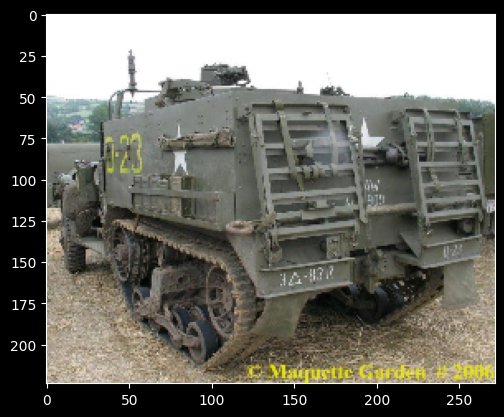

In [17]:
result = {'img_path':
        "D:/Data/ImageNet-EVAL/val_images/ILSVRC2012_val_00000035.JPEG",
        'seg_map_path':
            "D:/Data/ADEChallengeData2016/annotations/training/ADE_train_00000059.png",
            'reduce_zero_label':True,'seg_fields':[]}
for t in transforms:
    result = t(result)
result['inputs'] = [result['inputs']]
result['data_samples'] = [result['data_samples']]
print(result['inputs'][0].shape)
plt.imshow(result['inputs'][0].permute(1,2,0).numpy()[...,::-1])
#model.data_preprocessor.size_divisor = None
result = model.data_preprocessor(result,training=False)
print(result['inputs'].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


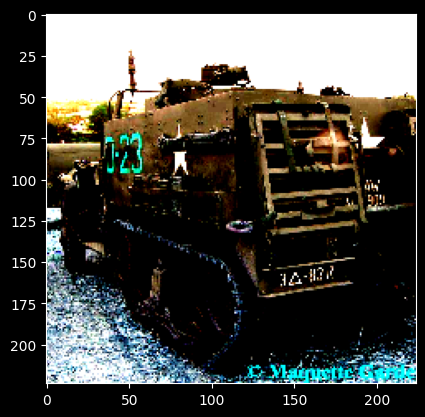

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([586])


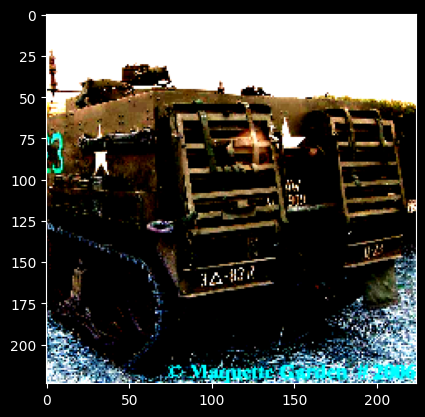

tensor([586])


In [18]:
h_stride, w_stride = config.model.test_cfg.stride
h_crop, w_crop = config.model.test_cfg.crop_size
batch_size, _, h_img, w_img = result['inputs'].size()
h_grids = max(h_img - h_crop + h_stride - 1, 0) // h_stride + 1
w_grids = max(w_img - w_crop + w_stride - 1, 0) // w_stride + 1
preds = result['inputs'].new_zeros((batch_size, 150, h_img, w_img))
count_mat = result['inputs'].new_zeros((batch_size, 1, h_img, w_img))
for h_idx in range(h_grids):
    for w_idx in range(w_grids):
        y1 = h_idx * h_stride
        x1 = w_idx * w_stride
        y2 = min(y1 + h_crop, h_img)
        x2 = min(x1 + w_crop, w_img)
        y1 = max(y2 - h_crop, 0)
        x1 = max(x2 - w_crop, 0)
        crop_img = result['inputs'][:, :, y1:y2, x1:x2]
        plt.imshow(crop_img.squeeze().permute(1,2,0).numpy()[...,::-1])
        plt.show()
        crop_seg_logit = model.backbone.forward_features(crop_img)
        print(torch.argmax(model.backbone.forward_head(crop_seg_logit),dim=1))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([586])


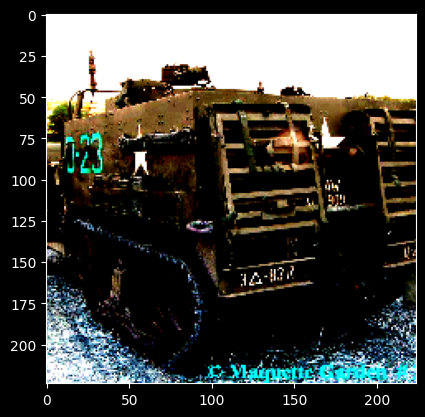

In [19]:
new_img = CenterCrop((224,224))(result['inputs'])
plt.imshow(new_img.squeeze().permute(1,2,0).numpy()[...,::-1])

with torch.autocast(device_type='cuda', dtype=torch.float32):
    crop_seg_logit = model.backbone.forward_features(CenterCrop((224,224))(result['inputs']))
    print(torch.argmax(model.backbone.forward_head(crop_seg_logit),dim=1))